#### Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sbn
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
import collections as col
import geopandas as gpd
from descartes import PolygonPatch

### Import dataset

In [3]:
gens = pd.read_csv("/Users/georgekoliopoulos/Desktop/renewable_generators.csv")

In [4]:
gens.head()

,Unnamed: 0,id,generator_name,country,ic_kw,technology,subsidy,accreditation,commissioned,rlf,alf,latest_data,latest_mwh_p_a,latest_rocs_p_a
0,0,C00083RAEN,Drax Biomass Conversion,England,1295000,Dedicated biomass,RO,2003-03-01,2013-04-02,79.2%,68.4%,2018-03,7761720.0,7761720.0
1,1,INVDRX001,DRAX Biomass Conversion CfD,England,645000,Dedicated biomass,CfD,2016-12-21,2016-12-21,71.2%,73.0%,2018-06,4124530.0,NaN
2,2,R00021RPEN,London Array Offshore Windfarm,England,630000,Off-shore wind,RO,2012-11-04,2012-11-04,40.9%,41.3%,2018-04,2278850.0,4231750.0
3,3,R00080RAEN,Tilbury Dedicated Biomass Power Station,England,1131000,Dedicated biomass,RO,2002-08-01,1968-01-01,45.4%,62.4%,2013-08,4100710.0,5353980.0
4,4,R00032RPEN,Race Bank,England,573300,Off-shore wind,RO,2017-06-08,2017-06-08,NaN,NaN,2018-05,1869200.0,2774550.0


### Delete the first column

In [5]:
gens.drop(gens.columns[[0]], 1, inplace=True)
gens.head()

,id,generator_name,country,ic_kw,technology,subsidy,accreditation,commissioned,rlf,alf,latest_data,latest_mwh_p_a,latest_rocs_p_a
0,C00083RAEN,Drax Biomass Conversion,England,1295000,Dedicated biomass,RO,2003-03-01,2013-04-02,79.2%,68.4%,2018-03,7761720.0,7761720.0
1,INVDRX001,DRAX Biomass Conversion CfD,England,645000,Dedicated biomass,CfD,2016-12-21,2016-12-21,71.2%,73.0%,2018-06,4124530.0,NaN
2,R00021RPEN,London Array Offshore Windfarm,England,630000,Off-shore wind,RO,2012-11-04,2012-11-04,40.9%,41.3%,2018-04,2278850.0,4231750.0
3,R00080RAEN,Tilbury Dedicated Biomass Power Station,England,1131000,Dedicated biomass,RO,2002-08-01,1968-01-01,45.4%,62.4%,2013-08,4100710.0,5353980.0
4,R00032RPEN,Race Bank,England,573300,Off-shore wind,RO,2017-06-08,2017-06-08,NaN,NaN,2018-05,1869200.0,2774550.0


### Select the column that we will work with

In [6]:
df = gens[['generator_name', 'country', 'ic_kw', 'technology', 'accreditation']].copy()
df.head()

,generator_name,country,ic_kw,technology,accreditation
0,Drax Biomass Conversion,England,1295000,Dedicated biomass,2003-03-01
1,DRAX Biomass Conversion CfD,England,645000,Dedicated biomass,2016-12-21
2,London Array Offshore Windfarm,England,630000,Off-shore wind,2012-11-04
3,Tilbury Dedicated Biomass Power Station,England,1131000,Dedicated biomass,2002-08-01
4,Race Bank,England,573300,Off-shore wind,2017-06-08


### Replace 'Photovoltaic' with 'Solar' to match the other datasets  

In [7]:
df.technology = df.technology.replace(to_replace='Photovoltaic', value='Solar')

### Checking for missing values

In [8]:
df.isnull().any()

generator_name    False
country           False
ic_kw             False
technology        False
accreditation      True
dtype: bool

### Deleting rows with missing values

In [9]:
df=df.dropna()

### Check again for missing values

In [10]:
df.isnull().any()

generator_name    False
country           False
ic_kw             False
technology        False
accreditation     False
dtype: bool

### Create new column with Accreditation year

In [11]:
df['accreditation'] =  pd.to_datetime(df['accreditation'], format='%Y-%m-%d')
accr_year=df.accreditation.dt.year
df['accr_year']=accr_year

### Function to find the total installed capacity in GWh for any column

In [12]:
def capacities(column):
    column_values = column.unique()
    capacity_per_column = {}
    for value in column_values:
        capacity = df[column==value].ic_kw.sum()
        capacity_per_column[value] = capacity/1000000
    return(capacity_per_column)   
    print(capacity_per_column)

### Total capacity per country

In [13]:
capacities(df.country)

{'England': 25.8953, 'Wales': 2.755594, 'Scotland': 10.393449, 'NI': 1.410483}

### Capacity per Country Bar Plot

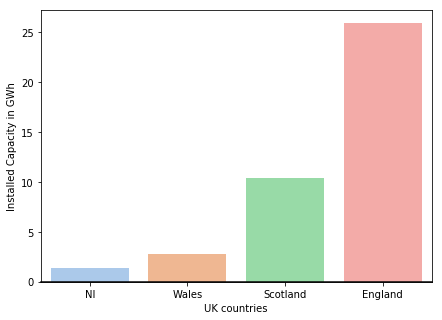

In [21]:
capacity_per_technology = capacities(df.technology)
capacity_per_country = col.OrderedDict(sorted(capacities(df.country).items(), key=lambda t: t[1]))
f, ax = plt.subplots(figsize=(7, 5), sharex=True)
sbn.barplot(x=list(capacity_per_country.keys()), y=list(capacity_per_country.values()), palette="pastel", ax=ax)
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("Installed Capacity in GWh")
ax.set_xlabel("UK countries")
#ax.set_title("Capacity of Renewable Generators per UK country")
plt.savefig('plots/cap_country.jpg')

### Merge Technologies of less than 1GWh capacity to "Other"

In [23]:
other = 0
to_be_deleted = []
for technology in capacity_per_technology:
    if capacity_per_technology[technology] < 1:
        other += capacity_per_technology[technology]
        to_be_deleted.append(technology)
capacity_per_technology.update({'Other' : other})
print(to_be_deleted)
for k in to_be_deleted:
    del capacity_per_technology[k]
print(capacity_per_technology)

['Enhanced Wave', 'Wave Power', 'Tidal Stream', 'Unknown Biomass', 'Standard Gasification', 'Advanced Gasification', 'Sewage Gas', 'Anaerobic Digestion', 'Waste']
OrderedDict([('Landfill Gas', 1.137663), ('Biomass co-firing', 1.591965), ('Hydro', 2.452584), ('Dedicated biomass', 4.943017), ('Off-shore wind', 7.78085), ('Solar', 8.192768), ('On-shore wind', 12.547192), ('Other', 1.8087869999999997)])


### Capacity per Technology Bar Plot

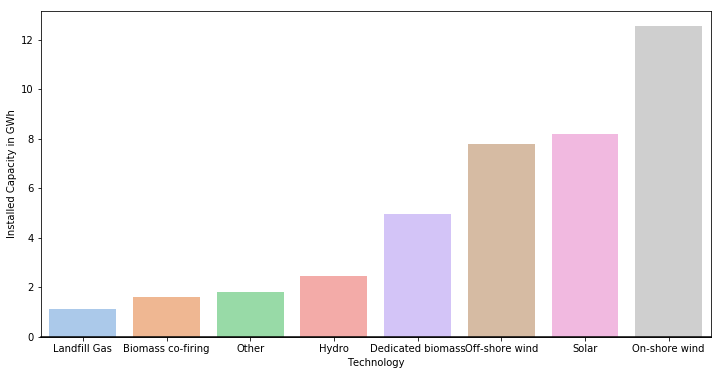

In [43]:
capacity_per_technology = col.OrderedDict(sorted(capacity_per_technology.items(), key=lambda t: t[1]))
f, ax = plt.subplots(figsize=(12, 6), sharex=True)
sbn.barplot(x=list(capacity_per_technology.keys()), y=list(capacity_per_technology.values()), palette="pastel", ax=ax)
ax.axhline(0, color="k", clip_on=False)
ax.set_ylabel("Installed Capacity in GWh")
ax.set_xlabel("Technology")
#ax.set_title("Capacity of Renewable Generators per technology")
plt.savefig('plots/cap_tech.jpg')

### Capacity of Technologies per country Plot

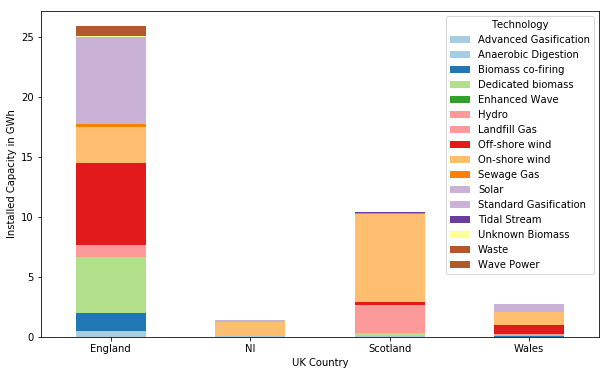

In [40]:
df['ic_gw'] = df.ic_kw/1000000
cap_country_tech = df.groupby(['country', 'technology'])['ic_gw'].sum().unstack()
cap_country_tech.plot(kind='bar', stacked=True, figsize=[10,6], colormap='Paired')
plt.ylabel("Installed Capacity in GWh")
plt.xlabel("UK Country")
# plt.title("Capacity of technologies in each country")
plt.xticks(rotation='horizontal')
plt.legend(title="Technology")
plt.savefig('plots/cap_country_tech')

### Time Series Plot for capacity per technology for each country

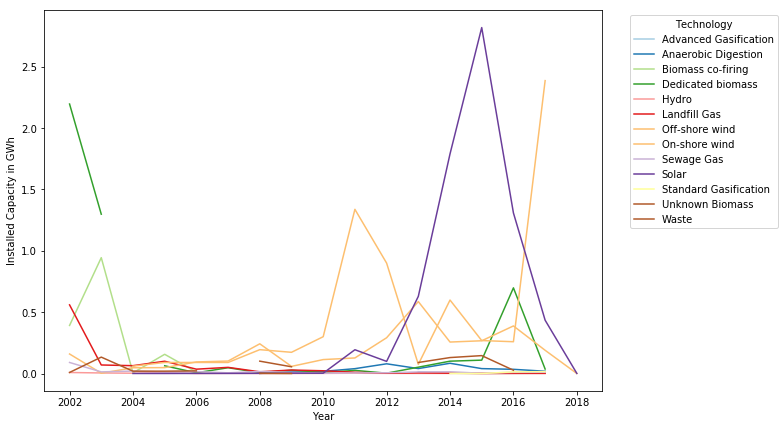

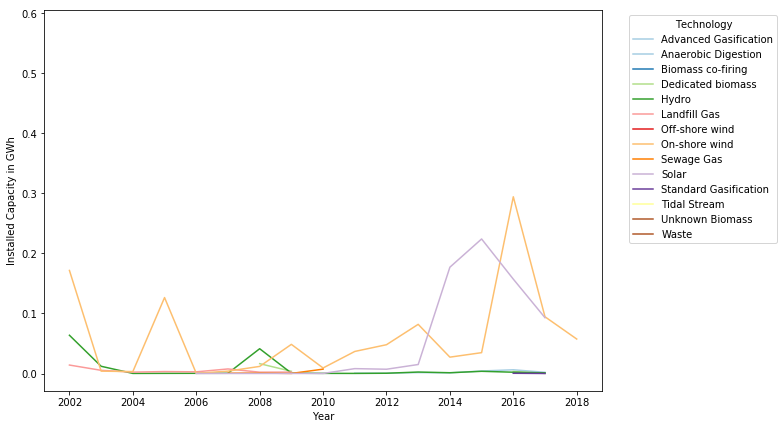

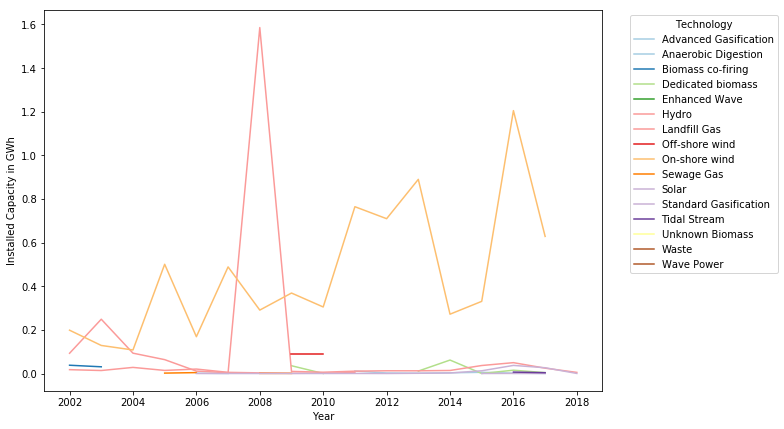

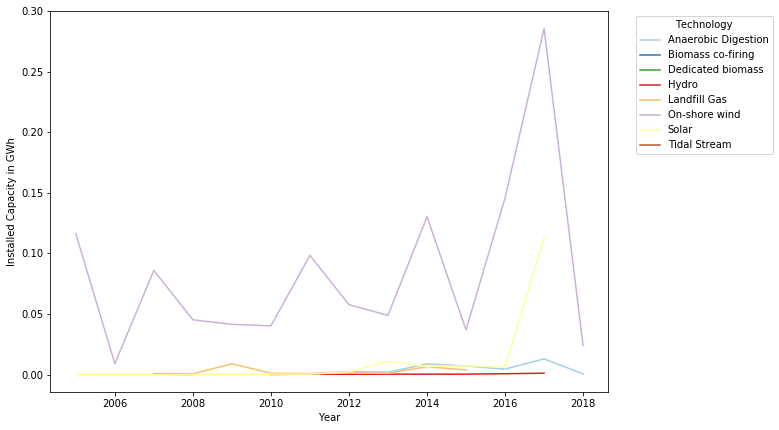

In [36]:
countries = df.country.unique()
for country in countries:    
    country_df = df[df.country==country]
    cap_by_year= country_df.groupby(['accr_year', 'technology'])['ic_gw'].sum()
    cap_by_year.unstack().plot(kind='line', figsize=[10,7], colormap='Paired')
    plt.ylabel("Installed Capacity in GWh")
    plt.xlabel("Year")
    #plt.title("Time Series Plot of installed capacity in " + country)
    plt.legend(title="Technology", bbox_to_anchor=(1.04,1), loc="upper left")
    plt.savefig('plots/time_'+ country, bbox_inches='tight')

### Import Shape of UK 
(source: https://data.gov.uk/dataset/b97c7f38-607c-4e1c-bdf1-db08b55b7566/countries-december-2017-full-extent-boundaries-in-uk)

In [19]:
fp = '/Users/georgekoliopoulos/Desktop/Countries_December_2017_Full_Extent_Boundaries_in_UK/Countries_December_2017_Full_Extent_Boundaries_in_UK.shp'
map_df = gpd.read_file(fp)
map_df.ctry17nm.replace(to_replace='Northern Ireland', value='NI', inplace=True)
map_df['total_capacity']= map_df['ctry17nm'].map(capacities(df.country))
map_df.head()

,objectid,ctry17cd,ctry17nm,ctry17nmw,bng_e,bng_n,long,lat,st_areasha,st_lengths,geometry,total_capacity
0,1,E92000001,England,Lloegr,394881,370341,-2.07813,53.230099,1.329461e+11,4.776071e+06,(POLYGON ((-2.03012376293311 55.80991509288915...,25.895300
1,2,N92000002,NI,Gogledd Iwerddon,86544,535337,-6.85570,54.615009,1.432976e+10,1.131048e+06,(POLYGON ((-6.483071331434693 55.2519503190522...,1.410483
2,3,S92000003,Scotland,Yr Alban,277746,700060,-3.97091,56.177429,8.022646e+10,1.790847e+07,(POLYGON ((-3.377188012939704 58.6725886008950...,10.393449
3,4,W92000004,Wales,Cymru,263406,242881,-3.99416,52.067410,2.122477e+10,2.027624e+06,(POLYGON ((-3.313849121291652 53.3611569749695...,2.755594


### Map of the UK with installed capacity per country

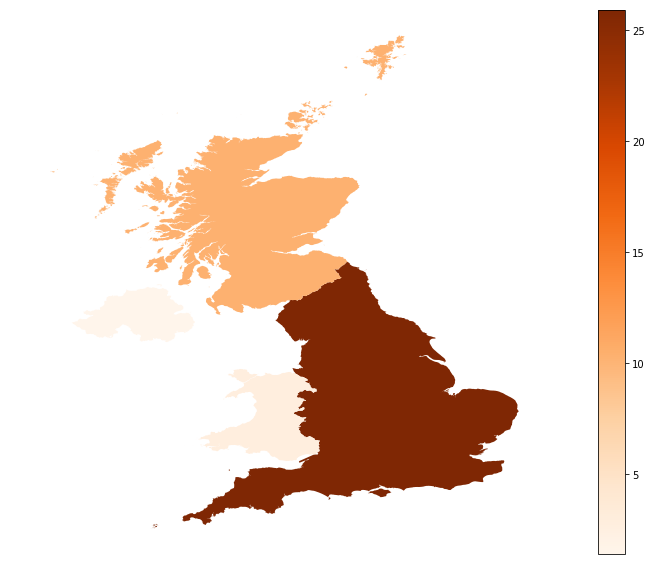

In [39]:
map = map_df.plot(column="total_capacity", figsize=(20,10), cmap='Oranges', legend = True)
map.axis('off')
#plt.title('Total Installed Capacity in GWh per country')
plt.savefig('plots/map')